<a href="https://colab.research.google.com/github/karenbennis/Xy/blob/mess_management/uniform_yelp_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connect to Database**

In [1]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

#Interact with SQL
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

# Start Spark Session(Creating spark application with name defined by appName()) ---IMPORTED WITH EVERY COLAB NOTEBOOK
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("database_transformation").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

--2020-07-31 04:31:03--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.58MB/s    in 0.2s    

2020-07-31 04:31:04 (4.58 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [2]:
# gcloud login and check the DB
!gcloud auth login
!gcloud config set project 'xy-yelp'
!gcloud sql instances describe 'xy-yelp'

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=l4Xeq-o79CEzRva7c3Y4uXiwvdhAXOFiGkViPHAuauw&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/2gHr6HnlvvEy99u07QK2-TtY-AmXI9WyhxtyCMI_0Pi10jJuaYYlhFA

You are now logged in as [jasmeersangha@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey

Updated property [core/project].
backendType: SECOND_GEN
conn

In [3]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy
# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="xy-yelp:northamerica-northeast1:xy-yelp"=tcp:5432 &
!sleep 30s

--2020-07-31 04:31:37--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 173.194.215.136, 173.194.215.93, 173.194.215.190, ...
Connecting to dl.google.com (dl.google.com)|173.194.215.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14492253 (14M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  13.82M  --.-KB/s    in 0.06s   

2020-07-31 04:31:37 (233 MB/s) - ‘cloud_sql_proxy’ saved [14492253/14492253]

nohup: appending output to 'nohup.out'


In [4]:
db_password = 'kjhbyelpdb'

In [5]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://127.0.0.1:5432/xy_yelp_db"
config = {"user":"postgres", 
          "password": db_password, 
          "driver":"org.postgresql.Driver"}

In [6]:
# Read data from database
review_df2 = spark.read.jdbc(url=jdbc_url, table='review_two', properties=config)
business_df2 = spark.read.jdbc(url=jdbc_url, table='business_two', properties=config)
user_df2 = spark.read.jdbc(url=jdbc_url, table='yelp_user_two', properties=config)

In [7]:
# Join tables
review_df2 = review_df2.join(business_df2, on="review_id", how="inner")
review_df2 = review_df2.join(user_df2, on="review_id", how="inner")
review_df2.show(5)

+--------------------+--------------------+-----+----+------+-----+-----------+--------------------+--------------------+
|           review_id|         review_text|stars|cool|useful|funny|review_date|         business_id|             user_id|
+--------------------+--------------------+-----+----+------+-----+-----------+--------------------+--------------------+
|06FL63x1PSHK1IE3i...|An hour and a hal...|    1|   0|     0|    0| 2016-01-24|Z3ZSar8IVAR2qIupq...|1luyQBuF2iH1Tbqs3...|
|1lGcbt9vMSWY5NLbW...|J'ai été séduite ...|    2|   0|     2|    0| 2015-01-27|frVru1HZYyGZ9sfbO...|AK4k713ocyWht0W47...|
|1xXPggQNNBjkwxxwH...|I'm always game t...|    1|   0|     2|    0| 2014-01-22|6tY0tn39Mb8FCLYBA...|gaPf1qNX7PAf14wIP...|
|37Ci4Q8bRm3PyYHZH...|Hmmm, it was okay...|    3|   1|     1|    0| 2010-01-17|Rj-7ymdw8aNZBRqGR...|uj4iopBWA0RjpqoJ5...|
|37FEOT7W5jpApoad7...|My wife and I had...|    1|   0|     0|    0| 2017-01-25|TTDMJetAQKfxVzKZy...|x20piGQtvm8hOKe8E...|
+--------------------+--

In [8]:
# Import pandas and read json file into DataFrame
import pandas as pd
raw_json = review_df2.toPandas()

In [10]:
#Drop useless columns
raw_json=raw_json[['review_id','stars','review_text','cool','useful','funny','business_id','user_id']]

In [12]:
# Show dataframe
raw_json['length']=raw_json['review_text'].apply(len)
raw_json.head()

,review_id,stars,review_text,cool,useful,funny,business_id,user_id,length
0,06FL63x1PSHK1IE3iQ3yqg,1,An hour and a half waiting for a pizza!!!!!! T...,0,0,0,Z3ZSar8IVAR2qIupqxMynA,1luyQBuF2iH1Tbqs331uGA,113
1,1lGcbt9vMSWY5NLbW5jx3g,2,J'ai été séduite par l'originalité du lieu qui...,0,2,0,frVru1HZYyGZ9sfbOchaXg,AK4k713ocyWht0W47DvV_g,582
2,1xXPggQNNBjkwxxwHnSHfQ,1,I'm always game to trying all Chinese take-out...,0,2,0,6tY0tn39Mb8FCLYBAXXOUw,gaPf1qNX7PAf14wIPBUmVg,858
3,37Ci4Q8bRm3PyYHZHwbFFQ,3,"Hmmm, it was okay I guess. Nothing wrong, but ...",1,1,0,Rj-7ymdw8aNZBRqGRAjR3Q,uj4iopBWA0RjpqoJ5xz_vQ,1453
4,37FEOT7W5jpApoad7d-23Q,1,My wife and I had chosen to fly with your airl...,0,0,0,TTDMJetAQKfxVzKZy4Z_2Q,x20piGQtvm8hOKe8EkR0VQ,2539


In [13]:
raw_json['stars']=raw_json['stars'].astype(str)
raw_json.dtypes

review_id      object
stars          object
review_text    object
cool            int32
useful          int32
funny           int32
business_id    object
user_id        object
length          int64
dtype: object

In [14]:
raw_json['user_id'].value_counts()

bLbSNkLggFnqwNNzzq-Ijw    7
PKEzKWv_FktMm2mGPjwd0Q    6
tWBLn4k1M7PLBtAtwAg73g    6
DK57YibC5ShBmqQl97CKog    6
CxDOIDnH8gp9KXzpBHJYXw    5
                         ..
ylv8cxFYfnCJPkrDN_GN7g    1
kvi3ZBaiF8YfKNv8egJQDg    1
FLib-wCiiURajYBE9KItLQ    1
cERUSNop4_9UN9auMY4yBw    1
eRvPOtsjkzTjn0f__HaXKQ    1
Name: user_id, Length: 9530, dtype: int64

In [15]:
raw_json['business_id'].value_counts()

5LNZ67Yw9RD6nf4_UhXOjw    14
K7lWdNUhCbcnEvI0NhGewg    14
AV6weBrZFFBfRGCbcRGO4g    13
RESDUcs7fIiihp38-d6_6g    13
XXW_OFaYQkkGOGniujZFHg    12
                          ..
rma3-6d-moBzHhJAtEdx6w     1
jlcnzJ_0Sr2w3l7Z9HaVow     1
k5WJVoO5WIv8XWjKTJ6vTA     1
zc12Q8war0hzXivKk3a8oQ     1
DpCdZ3EfAoGgJzcvaR0quQ     1
Name: business_id, Length: 8063, dtype: int64

**Visualizations**

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


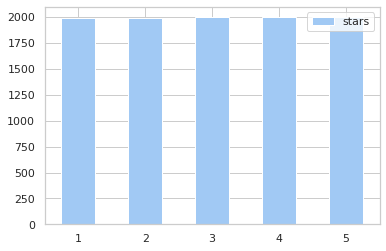

In [18]:
stars_count = raw_json.stars.value_counts()
df = pd.DataFrame(stars_count).sort_index()
df.plot.bar(rot=0)
plt.show()

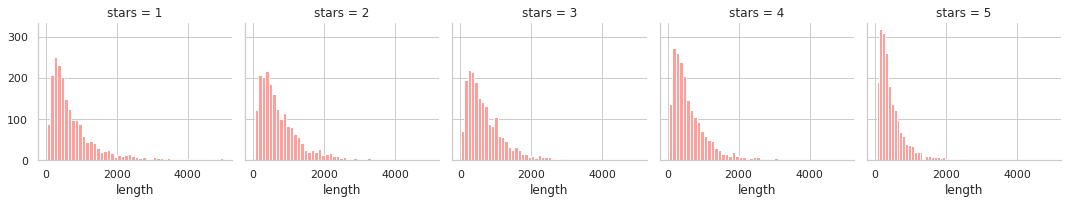

In [19]:
# COMPARING TEXT LENGTH TO STARS

star_length_plot = sns.FacetGrid(data=raw_json,col='stars')
star_length_plot.map(plt.hist,'length',bins=50,color='r')

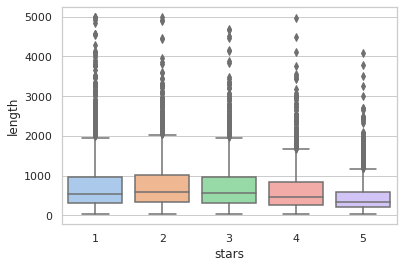

In [20]:
sns.boxplot(x="stars", y="length", data=raw_json)

In [23]:
review_metrics = raw_json.groupby("stars").mean()
review_metrics = review_metrics[['length', 'cool', 'useful', 'funny']]
review_metrics

,length,cool,useful,funny
stars,,,,
1,781.269674,0.255138,2.382456,0.749875
2,769.613534,0.417043,1.590476,0.671679
3,731.121622,0.702703,1.420420,0.687187
4,635.483242,0.845923,1.337169,0.563782
5,472.911411,0.513013,0.986987,0.363363


In [24]:
review_metrics.corr()

,length,cool,useful,funny
length,1.000000,-0.330942,0.780337,0.985401
cool,-0.330942,1.000000,-0.648546,-0.298789
useful,0.780337,-0.648546,1.000000,0.818380
funny,0.985401,-0.298789,0.818380,1.000000


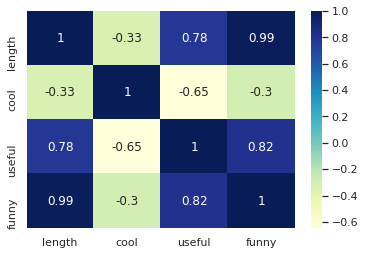

In [25]:
sns.heatmap(review_metrics.corr(), cmap="YlGnBu", annot=True)

In [26]:
df = raw_json.assign(Useful='No')
df.loc[raw_json['useful'] > 0, 'Useful'] = 'Yes'

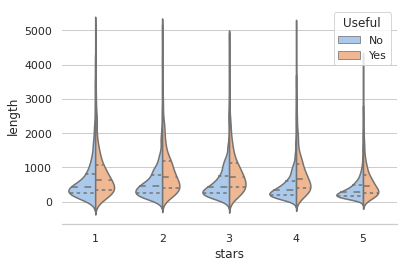

In [27]:
sns.violinplot(x="stars", y="length", hue="Useful",
               split=True, inner="quart",
               data=df)
sns.despine(left=True)

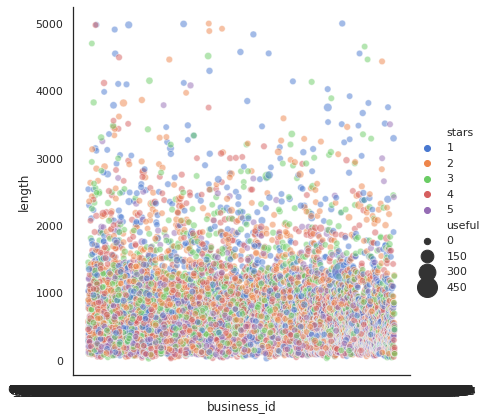

In [28]:
sns.set(style="white")
# Plot business id against length with other semantics
sns.relplot(x="business_id", y="length", hue="stars", size="useful",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

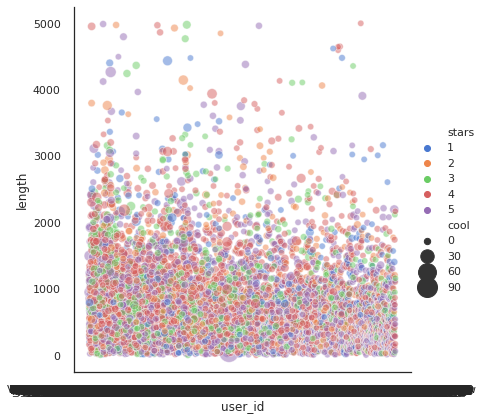

In [ ]:
sns.relplot(x="user_id", y="length", hue="stars", size="cool",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

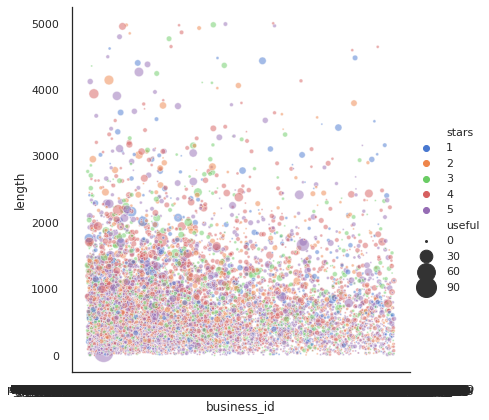

In [ ]:
sns.relplot(x="business_id", y="length", hue="stars", size="useful",
            sizes=(4, 400), alpha=.5, palette="muted",
            height=6, data=df)